# Ablation Study 1 - Simple Regression Model for Classification

##### This notebook contains all the code necessary to perform our first ablation test. Here, we are seeing if using a simple logistic regression model based on the three peak fit parameters (height, width, and position) can successfully classify a pixel into material vs. substrate.

# Load in Libraries, Data Files, and Ground Truth Data

In [ ]:
import hyperspy.api as hs
import hyperspy.signal_tools as hs_st
import hyperspy.axes as axes
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from hyperspy.signals import Signal1D
from tqdm import tqdm
import csv
import os
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from Ground_Truth_Creator import getGT
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from PIL import Image, ImageEnhance
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

hs.set_log_level('INFO')

In [3]:
# Loop through tif stacks to load in data as well as the ground truth results

# Define the folder path
folder_path = 'Time Series Oxidation Files'
full_path = os.path.join(os.getcwd(), folder_path)

file_list = []
for item in os.listdir('Time Series Oxidation Files'):
    if item.endswith('.tif'):
        file_list.append(item)

data_list = []
for item in tqdm(file_list):
    file_path = os.path.join(full_path, item)
    data_list.append(getGT(file_path))

100%|██████████| 16/16 [01:57<00:00,  7.33s/it]


# Data Frame Creation and Visualization

In [4]:
height_Array = []
position_Array = []
width_Array = []
time_Array = []
classification_Array = []


folder_path = 'Peak Parameter CSV Files'
full_path = os.path.join(os.getcwd(), folder_path)

# Loop through .csv files containing curve fit parameters and organize arrays for
# each peak fit parameter
for file in tqdm(os.listdir(full_path)):
    file_path = os.path.join(full_path, file)
    if file.endswith('Amp.csv'):
        with open(file_path, 'r') as f:
            reader = csv.reader(f)
            data = list(reader)
            amp_data = list(np.array(data).flatten())
            height_Array = height_Array + amp_data
            time = int(file.split('min')[0])
            time_Array = time_Array + list(np.ones(90000)*time)

    elif file.endswith('Center.csv'):
        with open(file_path, 'r') as f:
            reader = csv.reader(f)
            data = list(reader)
            center_data = list(np.array(data).flatten())
            position_Array = position_Array + center_data

    elif file.endswith('Sigma.csv'):
        with open(file_path, 'r') as f:
            reader = csv.reader(f)
            data = list(reader)
            sigma_data = list(np.array(data).flatten())
            width_Array = width_Array + sigma_data

for item in data_list:
    classification_Array = classification_Array + item

# Combine into one large array and process into dataframe
data_Array = np.array([height_Array, position_Array, width_Array, classification_Array, time_Array]).T

100%|██████████| 48/48 [00:05<00:00,  8.46it/s]


In [5]:
Curve_DF = pd.DataFrame(data_Array, columns=['Height', 'Center', 'Width', 'Classification', 'Time'], dtype='float')
Curve_DF

,Height,Center,Width,Classification,Time
0,0.026927,622.566373,80.228225,1.0,0.0
1,0.047228,634.106517,7.209891,0.0,0.0
2,0.126037,580.254087,0.572784,0.0,0.0
3,-0.145994,665.365131,1.132083,0.0,0.0
4,0.201331,645.307784,0.570608,0.0,0.0
...,...,...,...,...,...
1439995,0.058001,601.518309,38.623101,1.0,15.0
1439996,0.120802,592.727704,8.384419,1.0,15.0
1439997,0.108746,592.712819,16.440437,1.0,15.0
1439998,0.050630,592.613385,25.959486,1.0,15.0


In [ ]:
# Create dataframes for each time point
dataframes = []
for k in tqdm(range(16)):
    dataframes.append(Curve_DF.loc[[i for i in range(len(Curve_DF)) if Curve_DF['Time'][i] == k]])

### Get accuracy scores for each time step

In [ ]:
scaler = StandardScaler()
counter = 0
for frame in dataframes:
    x_train, x_test, y_train, y_test = train_test_split(scaler.fit_transform(frame[['Height', 'Center', 'Width']]), frame['Classification'], train_size=0.8)
    LogReg = LogisticRegression(class_weight={1:2, 0:1}, solver='lbfgs')
    LogReg.fit(x_train, y_train)
    print(f"df{counter} Accuracy = {np.round(LogReg.score(x_test, y_test), 5)}")
    counter += 1

### Get total accuracy and compute confusion matrix

Accuracy = 0.47719


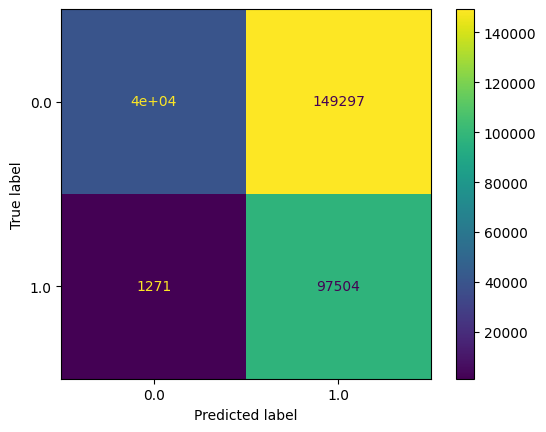

In [7]:
# Scale original data and use class_weight function to balance the mismatch in classes
scaler = StandardScaler()
x_train, x_test, y_train, y_test = train_test_split(scaler.fit_transform(Curve_DF[['Height', 'Center', 'Width']]), Curve_DF['Classification'], train_size=0.8)
LogReg = LogisticRegression(class_weight={1:2, 0:1}, solver='lbfgs')
LogReg.fit(x_train, y_train)
print(f"Accuracy = {np.round(LogReg.score(x_test, y_test), 5)}")
ConfusionMatrixDisplay.from_predictions(y_test, LogReg.predict(x_test), display_labels=LogReg.classes_, cmap='viridis')
plt.show()